# Convolutional β-Variational Autoencoder: MNIST & PyTorch

In [1]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER = PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import plotly, pickle
import plotly.express as px
import seaborn as sns
import numpy as np

C:\Users\arjun\anaconda3\envs\torch-gpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print(f"torch version: {torch.__version__}")

torch version: 1.12.1


In [4]:
# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

Number of GPU(s) available = 1
Current GPU: 0
Current GPU name: NVIDIA GeForce RTX 3080 Laptop GPU


In [5]:
# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

Available device is cuda


In [6]:
# Specify hyper-parameters-
num_epochs = 50
batch_size = 256

In [7]:
def count_params(model):
    # Count number of layer-wise parameters and total parameters-
    tot_params = 0
    for param in model.parameters():
        # print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
        tot_params += param.nelement()
    return tot_params


### MNIST data pre-processing

In [8]:
# Define transformations for MNIST dataset-
# MNIST dataset statistics-
mean = np.array([0.1307])
std_dev = np.array([0.3081])

transforms_apply = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean = mean, std = std_dev)
    ]
)

In [9]:
path_to_data = "C:\\Users\\arjun\Downloads\\"

In [10]:
# Load MNIST dataset-
train_dataset = torchvision.datasets.MNIST(
    # root = './data', train = True,
    root = path_to_data + "data", train = True,
    transform = transforms_apply, download = True
)

test_dataset = torchvision.datasets.MNIST(
    # root = './data', train = False,
    root = path_to_data + "data", train = False,
    transform = transforms_apply
)

In [11]:
len(train_dataset.targets), len(train_dataset.data)

(60000, 60000)

In [12]:
len(test_dataset.targets), len(test_dataset.data)

(10000, 10000)

In [13]:
print(f"training dataset length/shape: {list(train_dataset.data.size())}")

training dataset length/shape: [60000, 28, 28]


In [14]:
print(f"mean = {train_dataset.data.float().mean() / 255:.4f}")
print(f"std dev = {train_dataset.data.float().std() / 255:.4f}")

mean = 0.1307
std dev = 0.3081


In [15]:
# Sanity check-
train_dataset.data.min(), train_dataset.data.max()

(tensor(0, dtype=torch.uint8), tensor(255, dtype=torch.uint8))

In [16]:
test_dataset.data.min(), test_dataset.data.max()

(tensor(0, dtype=torch.uint8), tensor(255, dtype=torch.uint8))

In [17]:
# Scale pixel values in the range 0 to 1
# To manually convert the pixel values in the range 0 to 1, divide the training and testing
# datasets by 255.0-
train = train_dataset.data.float() / 255.0
test = test_dataset.data.float() / 255.0

In [18]:
# Reshape to include gray-scale channel-
train = train.reshape(60000, 1, 28, 28)
test = test.reshape(10000, 1, 28, 28)

In [19]:
train.shape, test.shape

(torch.Size([60000, 1, 28, 28]), torch.Size([10000, 1, 28, 28]))

In [20]:
# Sanity check- min and max pixel values are in the range 0 to 1-
train.data.min(), train.data.max()

(tensor(0.), tensor(1.))

In [21]:
test.data.min(), test.data.max()

(tensor(0.), tensor(1.))

In [22]:
del train_dataset, test_dataset

In [23]:
# Create training and testing dataloaders-
train_loader = torch.utils.data.DataLoader(
    dataset = train, batch_size = batch_size,
    shuffle = True, pin_memory = True
)

test_loader = torch.utils.data.DataLoader(
    dataset = test, batch_size = batch_size,
    shuffle = False, pin_memory = True
)

In [24]:
print(f"Sizes of train_dataset: {len(train)} and test_dataet: {len(test)}")
print(f"Sizes of train_loader: {len(train_loader)} and test_loader: {len(test_loader)}")

Sizes of train_dataset: 60000 and test_dataet: 10000
Sizes of train_loader: 235 and test_loader: 40


In [25]:
print(f"len(train_loader) = {len(train_loader)} & len(test_loader) = {len(test_loader)}")

len(train_loader) = 235 & len(test_loader) = 40


In [26]:
# Sanity check-
len(train) / batch_size, len(test) / batch_size

(234.375, 39.0625)

In [26]:
# Get some random batch of training images & labels-
images = next(iter(train_loader))

# You get 64 images due to the specified batch size-
print(f"images.shape: {images.shape}")

images.shape: torch.Size([256, 1, 28, 28])


In [27]:
images.min(), images.max()

(tensor(0.), tensor(1.))

In [28]:
# De-normalize the batch of images-
images *= 255.0

images.min(), images.max()

(tensor(0.), tensor(255.))

In [29]:
# Reshape images for visualization-
images = images.view(-1, 1, 28, 28)

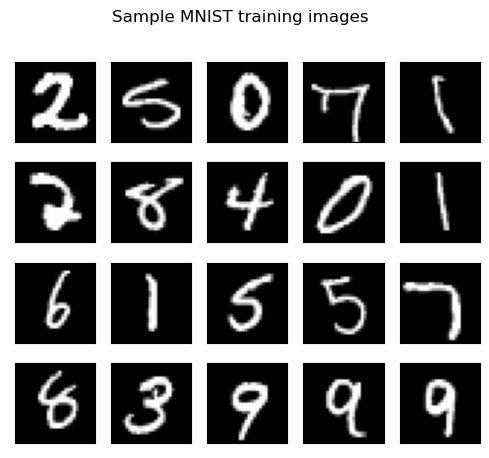

In [31]:
# Visualize 20 images from training set-
plt.figure(figsize = (6, 5))
for i in range(20):
    # 4 rows & 5 columns-
    plt.subplot(4, 5, i + 1)
    # plt.imshow(images[i], cmap = 'gray')
    # 0 to access first channel-
    plt.imshow(images[i][0], cmap = 'gray')
    
    # get current axes-
    ax = plt.gca()
    
    # hide x-axis-
    ax.get_xaxis().set_visible(False)
    
    # hide y-axis-
    ax.get_yaxis().set_visible(False)
    
plt.suptitle("Sample MNIST training images")
plt.show()

In [32]:
del images

### Define Convolutional VAE architecture

In [27]:
class Conv_Encoder(nn.Module):
    def __init__(self, latent_space = 3):
        super(Conv_Encoder, self).__init__()
        
        self.conv1 = nn.Conv2d(
            in_channels = 1, out_channels = 32,
            kernel_size = 3, stride = 1,
            padding = 0, bias = True
        )
        self.bn1 = nn.BatchNorm2d(num_features = 32)
        self.conv2 = nn.Conv2d(
            in_channels = 32, out_channels = 32,
            kernel_size = 3, stride = 1,
            padding = 0, bias = True
        )
        self.bn2 = nn.BatchNorm2d(num_features = 32)
        self.conv3 = nn.Conv2d(
            in_channels = 32, out_channels = 64,
            kernel_size = 3, stride = 2,
            padding = 0, bias = True
        )
        self.bn3 = nn.BatchNorm2d(num_features = 64)
        self.conv4 = nn.Conv2d(
            in_channels = 64, out_channels = 64,
            kernel_size = 3, stride = 1,
            padding = 0, bias = True
        )
        self.bn4 = nn.BatchNorm2d(num_features = 64)
        self.conv5 = nn.Conv2d(
            in_channels = 64, out_channels = 128,
            kernel_size = 3, stride = 1,
            padding = 0, bias = True
        )
        self.bn5 = nn.BatchNorm2d(num_features = 128)
        self.conv6 = nn.Conv2d(
            in_channels = 128, out_channels = 128,
            kernel_size = 3, stride = 2,
            padding = 0, bias = True
        )
        self.bn6 = nn.BatchNorm2d(num_features = 128)
        self.conv7 = nn.Conv2d(
            in_channels = 128, out_channels = 128,
            kernel_size = 3, stride = 1,
            padding = 0, bias = True
        )
        self.bn7 = nn.BatchNorm2d(num_features = 128)
        self.conv8 = nn.Conv2d(
            in_channels = 128, out_channels = latent_space,
            kernel_size = 1, stride = 1,
            padding = 0, bias = True
        )
        
        self.initialize_weights()
        
    
    def initialize_weights(self):
        for m in self.modules():
            # print(m)
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                
                # Do not initialize bias (due to batchnorm)-
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                
            elif isinstance(m, nn.BatchNorm2d):
                # Standard initialization for batch normalization-
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    
    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        # x = nn.SiLU()(self.bn1(self.conv1(x)))
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = F.leaky_relu(self.bn3(self.conv3(x)))
        x = F.leaky_relu(self.bn4(self.conv4(x)))
        x = F.leaky_relu(self.bn5(self.conv5(x)))
        x = F.leaky_relu(self.bn6(self.conv6(x)))
        x = F.leaky_relu(self.bn7(self.conv7(x)))
        x = F.leaky_relu(self.conv8(x))
        return x
    
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = self.conv1(x)
        print(f"conv1 output shape: {x.shape}")
        x = self.conv2(x)
        print(f"conv2 output shape: {x.shape}")
        x = self.conv3(x)
        print(f"conv3 output shape: {x.shape}")
        x = self.conv4(x)
        print(f"conv4 output shape: {x.shape}")
        x = self.conv5(x)
        print(f"conv5 output shape: {x.shape}")
        x = self.conv6(x)
        print(f"conv6 output shape: {x.shape}")
        x = self.conv7(x)
        print(f"conv7 output shape: {x.shape}")
        x = self.conv8(x)
        print(f"conv8 output shape: {x.shape}")
        # encoder output shape: torch.Size([256, 3, 1, 1])
        
        return None
    

In [28]:
class Conv_Decoder(nn.Module):
    def __init__(self, latent_space):
        super(Conv_Decoder, self).__init__()
        
        self.conv_tran1 = nn.ConvTranspose2d(
            in_channels = latent_space, out_channels = 32,
            kernel_size = 3, stride = 1,
            padding = 0
        )
        self.bn1 = nn.BatchNorm2d(num_features = 32) 
        self.conv_tran2 = nn.ConvTranspose2d(
            in_channels = 32, out_channels = 32,
            kernel_size = 3, stride = 1,
            padding = 1
        )
        self.bn2 = nn.BatchNorm2d(num_features = 32)
        self.conv_tran3 = nn.ConvTranspose2d(
            in_channels = 32, out_channels = 64,
            kernel_size = 3, stride = 2,
            padding = 0
        )
        self.bn3 = nn.BatchNorm2d(num_features = 64)
        self.conv_tran4 = nn.ConvTranspose2d(
            in_channels = 64, out_channels = 64,
            kernel_size = 3, stride = 1,
            padding = 1
        )
        self.bn4 = nn.BatchNorm2d(num_features = 64)
        self.conv_tran5 = nn.ConvTranspose2d(
            in_channels = 64, out_channels = 128,
            kernel_size = 3, stride = 1,
            padding = 0
        )
        self.bn5 = nn.BatchNorm2d(num_features = 128)
        self.conv_tran6 = nn.ConvTranspose2d(
            in_channels = 128, out_channels = 128,
            kernel_size = 3, stride = 1,
            padding = 0
        )
        self.bn6 = nn.BatchNorm2d(num_features = 128)
        self.conv_tran7 = nn.ConvTranspose2d(
            in_channels = 128, out_channels = 256,
            kernel_size = 3, stride = 2,
            padding = 0
        )
        self.bn7 = nn.BatchNorm2d(num_features = 256)
        self.conv_tran8 = nn.ConvTranspose2d(
            in_channels = 256, out_channels = 256,
            kernel_size = 3, stride = 1,
            padding = 0
        )
        self.bn8 = nn.BatchNorm2d(num_features = 256)
        self.conv_tran9 = nn.ConvTranspose2d(
            in_channels = 256, out_channels = 64,
            kernel_size = 3, stride = 1,
            padding = 0
        )
        self.bn9 = nn.BatchNorm2d(num_features = 64)
        self.conv_tran10 = nn.ConvTranspose2d(
            in_channels = 64, out_channels = 1,
            kernel_size = 2, stride = 1,
            padding = 0
        )
        
        self.initialize_weights()
        
    
    def initialize_weights(self):
        for m in self.modules():
            # print(m)
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                
                # Do not initialize bias (due to batchnorm)-
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                
            elif isinstance(m, nn.BatchNorm2d):
                # Standard initialization for batch normalization-
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    
    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv_tran1(x)))
        # x = nn.SiLU()(self.bn1(self.conv_tran1(x)))
        x = F.leaky_relu(self.bn2(self.conv_tran2(x)))
        x = F.leaky_relu(self.bn3(self.conv_tran3(x)))
        x = F.leaky_relu(self.bn4(self.conv_tran4(x)))
        x = F.leaky_relu(self.bn5(self.conv_tran5(x)))
        x = F.leaky_relu(self.bn6(self.conv_tran6(x)))
        x = F.leaky_relu(self.bn7(self.conv_tran7(x)))
        x = F.leaky_relu(self.bn8(self.conv_tran8(x)))
        x = F.leaky_relu(self.bn9(self.conv_tran9(x)))

        # Use sigmoid activation function due to data pre-processing-
        x = torch.sigmoid(self.conv_tran10(x))
        return x
    
    
    def shape_computation(self, x):
        # Input: torch.Size([256, 3, 1, 1])
        print(f"Input shape: {x.shape}")
        x = self.conv_tran1(x)
        print(f"conv transpose1 output shape: {x.shape}")
        x = self.conv_tran2(x)
        print(f"conv transpose2 output shape: {x.shape}")
        x = self.conv_tran3(x)
        print(f"conv transpose3 output shape: {x.shape}")
        x = self.conv_tran4(x)
        print(f"conv transpose4 output shape: {x.shape}")
        x = self.conv_tran5(x)
        print(f"conv transpose5 output shape: {x.shape}")
        x = self.conv_tran6(x)
        print(f"conv transpose6 output shape: {x.shape}")
        x = self.conv_tran7(x)
        print(f"conv transpose7 output shape: {x.shape}")
        x = self.conv_tran8(x)
        print(f"conv transpose8 output shape: {x.shape}")
        x = self.conv_tran9(x)
        print(f"conv transpose9 output shape: {x.shape}")
        x = self.conv_tran10(x)
        print(f"conv transpose10 output shape: {x.shape}")
        return None
        

In [29]:
class Conv_VAE(nn.Module):
    def __init__(self, latent_space = 3):
        super(Conv_VAE, self).__init__()
        
        self.encoder = Conv_Encoder(latent_space = latent_space)
        self.decoder = Conv_Decoder(latent_space = latent_space)
        
        # Define mean & log-variance vectors to represent latent space 'z'-
        self.mu = torch.nn.Linear(in_features = latent_space, out_features = latent_space)
        self.log_var = torch.nn.Linear(in_features = latent_space, out_features = latent_space)
    
    
    def reparameterize(self, mu, log_var):
        '''
        Input arguments:
        1. mu - mean coming from the encoder's latent space
        2. log_var - log variance coming from the encoder's latent space
        '''
        # Compute standard deviation using 'log_var'-
        std = torch.exp(0.5 * log_var)
        
        # 'eps' samples from a normal standard distribution to add
        # stochasticity to the sampling process-
        eps = torch.randn_like(std)
        
        # Reparameterization trick - sample as if it's from the input
        # space-
        z = mu + (std * eps)
        
        return z
    
    
    def forward(self, x):
        x = self.encoder(x)
        x = torch.reshape(x, (-1, 3))
        mu = self.mu(x)
        logvar = self.log_var(x)
        z = self.reparameterize(mu = mu, log_var = logvar)
        z = torch.reshape(z, (-1, 3, 1, 1))
        return self.decoder(z), mu, logvar
    
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = self.encoder(x)
        print(f"Encoder output shape: {x.shape}")
        
        x = torch.reshape(x, (-1, 3))
        print(f"Reshaped output shape: {x.shape}")
        mu = self.mu(x)
        logvar = self.log_var(x)
        print(f"mean shape: {mu.shape} & logvar shape: {logvar.shape}")
        z = self.reparameterize(mu = mu, log_var = logvar)
        print(f"z.shape: {z.shape}")
        z = torch.reshape(z, (-1, 3, 1, 1))
        print(f"reshaped z output shape: {z.shape}")
    
        x = self.decoder(z)
        print(f"Decoder output shape: {x.shape}")
        
        return None
    

In [30]:
# Initialize an instance of Conv-VAE-
model = Conv_VAE(latent_space = 3)

In [31]:
images = next(iter(train_loader))

In [32]:
model.shape_computation(images)

Input shape: torch.Size([256, 1, 28, 28])
Encoder output shape: torch.Size([256, 3, 1, 1])
Reshaped output shape: torch.Size([256, 3])
mean shape: torch.Size([256, 3]) & logvar shape: torch.Size([256, 3])
z.shape: torch.Size([256, 3])
reshaped z output shape: torch.Size([256, 3, 1, 1])
Decoder output shape: torch.Size([256, 1, 28, 28])


In [33]:
out, mu, logvar = model(images)

In [34]:
out.shape, mu.shape, logvar.shape

(torch.Size([256, 1, 28, 28]), torch.Size([256, 3]), torch.Size([256, 3]))

In [35]:
del out, mu, logvar

In [36]:
print(f"Total trainable parameters = {count_params(model = model)}")

Total trainable parameters = 1757660


In [37]:
def compute_total_loss(data, data_recon, mu, log_var, beta = 1):
    '''
    Function to compute loss = reconstruction loss * reconstruction_term_weight + KL-Divergence loss.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    
    Inputs:
    1. mu: mean from the latent vector
    2. logvar: log variance from the latent vector
    3. beta: beta parameter (beta-VAE paper by Higgins et al.)
    4. data: training data
    5. data_recon: VAE's reconstructed data
    '''
    
    batchsize = data.size(0)
    
    # Sum over latent dimensions-
    # kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - torch.exp(log_var))
    kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - torch.exp(log_var), dim = -1)
    
    # kl_div.shape
    # torch.Size([32])

    # Average over batch dimension-
    kl_div = kl_div.mean()
    
    reconstruction_loss_fn = F.mse_loss
    recon_loss = reconstruction_loss_fn(data_recon, data, reduction = 'none')
    
    # recon_loss.shape
    # torch.Size([32, 1, 28, 28])
    
    # Sum over all pixels-
    recon_loss = recon_loss.view(batchsize, -1).sum(axis = 1)
    
    # recon_loss.shape
    # torch.Size([32])
    
    # Average over mini-batch dimension-
    recon_loss = recon_loss.mean()
    
    final_loss = recon_loss + (beta * kl_div)
    
    return final_loss, recon_loss, kl_div


### Learning Rate Scheduler

An initial lr warmup followed by step-decays.

Training dataset = 60K, batch size = 256, number of training steps per epoch = 60K / 256 = 234.375.

After an initial lr warmup of 10 epochs or 2344 steps:

- For the next 20 epochs, or, 4688 steps - until 30th epoch, use lr = 0.1
- For the next 10 epochs, or, 2344 steps - until 40th epoch, use lr = 0.01
- For remaining epochs (10 epochs), use lr = 0.001

- Using SGD learning rate scheduler (defined below) leads to losses becoming ```nan```. However, using Adam lr scheduler overcomes this. _Do not use SGD with lr scheduler for this experiment!_

In [ ]:
'''
boundaries = [4688, 7032]
values = [0.1, 0.01, 0.001]
'''

In [38]:
# Define gradient descent optimizer-
# optimizer = torch.optim.SGD(model.parameters(), lr = 0.0, momentum = 0.9, weight_decay = 5e-4)
optimizer = torch.optim.Adam(model.parameters(), lr = 10e-3)

In [ ]:
# Sanity check-
# optimizer.param_groups[0]['lr']

In [33]:
def decay_function(
    step, boundaries = [4688, 7032],
    values = [0.1, 0.01, 0.001]
):
    
    for idx, bound in enumerate(boundaries):
        if step < bound:
            return values[idx]

    return values[-1]


In [34]:
class schedule():

    def __init__(
        self, initial_learning_rate = 0.1,
        warmup_steps = 1000, decay_func = None
    ):
        self.initial_learning_rate = initial_learning_rate
        self.warmup_steps = warmup_steps
        self.decay_func = decay_func
        self.warmup_step_size = initial_learning_rate/warmup_steps
        self.current_lr = 0

    def get_lr(self, step):
        if step == 0:
            return self.current_lr
        elif step <= self.warmup_steps:
            self.current_lr += self.warmup_step_size
            return self.current_lr
        elif step > self.warmup_steps:
            if self.decay_func:
                return self.decay_func(step)
        else:
            return self.current_lr
        

In [ ]:
'''
# Initial linear LR warmup: 234.375 x 10 = 2343.75 steps in 13 epochs.
custom_lr_scheduler = schedule(
    initial_learning_rate = 0.1, warmup_steps = 2344,
    decay_func = decay_function
)
'''

In [ ]:
# step = 0

In [48]:
def train_one_epoch(model, dataloader, dataset, beta):
    
    # Place model to device-
    model.to(device)
    
    # Enable training mode-
    model.train()
    
    # Initialize variables to keep track of 3 losses-
    running_final_loss = 0.0
    running_recon_loss = 0.0
    running_kl_loss = 0.0
    
    
    for i, data in tqdm(
        enumerate(dataloader),
        total = int(len(dataset) / dataloader.batch_size)
        ):
      
        # Push data points to 'device'-
        data = data.to(device)

        # Empty accumulated gradients-
        optimizer.zero_grad()
        
        # Perform forward propagation-
        recon, mu, logvar = model(data)
        
        final_loss, recon_loss, kl_div_loss = compute_total_loss(
            data = data, data_recon = recon,
            mu = mu, log_var = logvar,
            beta = beta
        )
        
        # Update losses-
        running_final_loss += final_loss.item()
        running_kl_loss += kl_div_loss.cpu().detach().numpy()
        running_recon_loss += recon_loss.cpu().detach().numpy()
        
        # Compute gradients wrt total loss-
        final_loss.backward()
        
        # Perform gradient descent-
        optimizer.step()
        
        '''
        global step
        optimizer.param_groups[0]['lr'] = custom_lr_scheduler.get_lr(step)
        step += 1
        '''
        
    # Compute losses as float values-
    train_loss = running_final_loss / len(dataloader.dataset)
    kl_loss = running_kl_loss / len(dataloader.dataset)
    recon_loss = running_recon_loss / len(dataloader.dataset)
    
    return train_loss, kl_loss, recon_loss


In [42]:
def validate_one_epoch(model, dataloader, dataset, beta):
    
    # Place model to device-
    # model.to(device)
    model.to(0)
    
    # Enable evaluation mode-
    model.eval()
    
    running_final_loss = 0.0
    running_recon_loss = 0.0
    running_kl_loss = 0.0
    
    with torch.no_grad():
        for i, data in tqdm(
            enumerate(dataloader),
            total = int(len(dataset) / dataloader.batch_size)
        ):
            # Push data points to 'device'-
            data = data.to(device)
            
            # Forward propagation-
            recon, mu, logvar = model(data)
            
            final_loss, recon_loss, kl_div_loss = compute_total_loss(
                data = data, data_recon = recon,
                mu = mu, log_var = logvar,
                beta = beta
            )
        
            # Update losses-
            running_final_loss += final_loss.item()
            running_kl_loss += kl_div_loss.cpu().detach().numpy()
            running_recon_loss += recon_loss.cpu().detach().numpy()
            
                
    val_loss = running_final_loss / len(dataloader.dataset)
    val_kl_loss = running_kl_loss / len(dataloader.dataset)
    val_recon_loss = running_recon_loss / len(dataloader.dataset)
    
    return val_loss, val_kl_loss, val_recon_loss


#### Do _not_ use ```earlystopping``` since lr scheduler is used

In [43]:
# Specify hyper-parameter-
beta = 1

In [50]:
# Python dict to contain training metrics-
train_history = {}

In [45]:
print(f"Training VAE model for {num_epochs} epochs")

Training VAE model for 50 epochs


In [46]:
# Initialize parameters for Early Stopping manual implementation-
best_val_loss = 10000
# loc_patience = 0

# User input parameters for Early Stopping in manual implementation-
# minimum_delta = 0.001
# patience = 3

In [51]:
for epoch in range(1, num_epochs + 1):
    '''
    # Manual early stopping implementation-
    if loc_patience >= patience:
        print("\n'EarlyStopping' called!\n")
        break
    '''
    
    # Train model for 1 epoch-
    train_loss, kl_train_loss, recon_train_loss = train_one_epoch(
        model = model, dataloader = train_loader,
        dataset = train, beta = beta
    )
    
    # Get validation after 1 epoch-
    val_loss, val_kl_loss, val_recon_loss = validate_one_epoch(
        model = model, dataloader = test_loader,
        dataset = test, beta = beta
    )
    
    # Store model performance metrics in Python3 dict-
    train_history[epoch] = {
        'train_loss': train_loss,
        'train_recon_loss': kl_train_loss,
        'train_kl_loss': kl_train_loss,
        'val_loss': val_loss,
        'val_recon_loss': val_recon_loss,
        'val_kl_loss': val_kl_loss,
        'lr': optimizer.param_groups[0]['lr']
    }
    
    print(f"Epoch = {epoch}; train loss = {train_loss:.4f}",
          f", kl-loss = {kl_train_loss:.4f}, recon loss = {recon_train_loss:.4f}",
          f", val loss = {val_loss:.4f}, val kl-loss = {val_kl_loss:.4f},",
          f" val recon loss = {val_recon_loss:.4f} &"
          f" LR = {optimizer.param_groups[0]['lr']:.4f}\n"
         )
    
    
    # Code for manual Early Stopping:
    if (val_loss < best_val_loss):
    # (np.abs(val_epoch_loss - best_val_loss) >= minimum_delta):

        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_loss = val_loss
        
        # reset 'loc_patience' variable-
        # loc_patience = 0

        print(f"Saving model with lowest val_loss = {val_loss:.4f}\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(model.state_dict(), "ConvVAE_MNIST_best_model.pth")
        
    '''
    else:  # there is no improvement in monitored metric 'val_loss'
        loc_patience += 1  # number of epochs without any improvement
    '''

235it [00:24,  9.47it/s]                                                                                               
40it [00:01, 22.78it/s]                                                                                                


Epoch = 1; train loss = 0.2228 , kl-loss = 0.0030, recon loss = 0.2198 , val loss = 0.2104, val kl-loss = 0.0024,  val recon loss = 0.2080 & LR = 0.0100

Saving model with lowest val_loss = 0.2104



235it [00:20, 11.32it/s]                                                                                               
40it [00:01, 35.50it/s]                                                                                                


Epoch = 2; train loss = 0.1919 , kl-loss = 0.0054, recon loss = 0.1865 , val loss = 0.1886, val kl-loss = 0.0078,  val recon loss = 0.1808 & LR = 0.0100

Saving model with lowest val_loss = 0.1886



235it [00:20, 11.57it/s]                                                                                               
40it [00:01, 35.27it/s]                                                                                                


Epoch = 3; train loss = 0.1772 , kl-loss = 0.0094, recon loss = 0.1679 , val loss = 0.1785, val kl-loss = 0.0104,  val recon loss = 0.1681 & LR = 0.0100

Saving model with lowest val_loss = 0.1785



235it [00:19, 11.80it/s]                                                                                               
40it [00:01, 35.20it/s]                                                                                                


Epoch = 4; train loss = 0.1716 , kl-loss = 0.0103, recon loss = 0.1612 , val loss = 0.1747, val kl-loss = 0.0113,  val recon loss = 0.1635 & LR = 0.0100

Saving model with lowest val_loss = 0.1747



235it [00:20, 11.72it/s]                                                                                               
40it [00:01, 35.08it/s]                                                                                                


Epoch = 5; train loss = 0.1681 , kl-loss = 0.0113, recon loss = 0.1568 , val loss = 0.1691, val kl-loss = 0.0117,  val recon loss = 0.1574 & LR = 0.0100

Saving model with lowest val_loss = 0.1691



235it [00:20, 11.72it/s]                                                                                               
40it [00:01, 34.75it/s]                                                                                                


Epoch = 6; train loss = 0.1672 , kl-loss = 0.0117, recon loss = 0.1555 , val loss = 0.1676, val kl-loss = 0.0121,  val recon loss = 0.1556 & LR = 0.0100

Saving model with lowest val_loss = 0.1676



235it [00:20, 11.70it/s]                                                                                               
40it [00:01, 33.88it/s]                                                                                                


Epoch = 7; train loss = 0.1642 , kl-loss = 0.0122, recon loss = 0.1520 , val loss = 0.1666, val kl-loss = 0.0125,  val recon loss = 0.1541 & LR = 0.0100

Saving model with lowest val_loss = 0.1666



235it [00:20, 11.71it/s]                                                                                               
40it [00:01, 34.84it/s]                                                                                                


Epoch = 8; train loss = 0.1633 , kl-loss = 0.0125, recon loss = 0.1508 , val loss = 0.1670, val kl-loss = 0.0129,  val recon loss = 0.1540 & LR = 0.0100



235it [00:20, 11.69it/s]                                                                                               
40it [00:01, 34.43it/s]                                                                                                


Epoch = 9; train loss = 0.1620 , kl-loss = 0.0128, recon loss = 0.1493 , val loss = 0.1649, val kl-loss = 0.0132,  val recon loss = 0.1518 & LR = 0.0100

Saving model with lowest val_loss = 0.1649



235it [00:20, 11.68it/s]                                                                                               
40it [00:01, 34.83it/s]                                                                                                


Epoch = 10; train loss = 0.1622 , kl-loss = 0.0128, recon loss = 0.1494 , val loss = 0.1636, val kl-loss = 0.0130,  val recon loss = 0.1506 & LR = 0.0100

Saving model with lowest val_loss = 0.1636



235it [00:20, 11.66it/s]                                                                                               
40it [00:01, 34.82it/s]                                                                                                


Epoch = 11; train loss = 0.1624 , kl-loss = 0.0129, recon loss = 0.1495 , val loss = 0.1690, val kl-loss = 0.0134,  val recon loss = 0.1556 & LR = 0.0100



235it [00:20, 11.65it/s]                                                                                               
40it [00:01, 34.79it/s]                                                                                                


Epoch = 12; train loss = 0.1634 , kl-loss = 0.0129, recon loss = 0.1504 , val loss = 0.1650, val kl-loss = 0.0132,  val recon loss = 0.1518 & LR = 0.0100



235it [00:20, 11.64it/s]                                                                                               
40it [00:01, 33.98it/s]                                                                                                


Epoch = 13; train loss = 0.1617 , kl-loss = 0.0130, recon loss = 0.1487 , val loss = 0.1633, val kl-loss = 0.0132,  val recon loss = 0.1501 & LR = 0.0100

Saving model with lowest val_loss = 0.1633



235it [00:20, 11.62it/s]                                                                                               
40it [00:01, 34.77it/s]                                                                                                


Epoch = 14; train loss = 0.1599 , kl-loss = 0.0132, recon loss = 0.1467 , val loss = 0.1625, val kl-loss = 0.0138,  val recon loss = 0.1488 & LR = 0.0100

Saving model with lowest val_loss = 0.1625



235it [00:20, 11.64it/s]                                                                                               
40it [00:01, 34.38it/s]                                                                                                


Epoch = 15; train loss = 0.1618 , kl-loss = 0.0132, recon loss = 0.1486 , val loss = 0.1628, val kl-loss = 0.0138,  val recon loss = 0.1490 & LR = 0.0100



235it [00:20, 11.63it/s]                                                                                               
40it [00:01, 34.70it/s]                                                                                                


Epoch = 16; train loss = 0.1593 , kl-loss = 0.0135, recon loss = 0.1459 , val loss = 0.1671, val kl-loss = 0.0140,  val recon loss = 0.1531 & LR = 0.0100



235it [00:20, 11.63it/s]                                                                                               
40it [00:01, 34.68it/s]                                                                                                


Epoch = 17; train loss = 0.1598 , kl-loss = 0.0135, recon loss = 0.1463 , val loss = 0.1635, val kl-loss = 0.0139,  val recon loss = 0.1496 & LR = 0.0100



235it [00:20, 11.63it/s]                                                                                               
40it [00:01, 34.60it/s]                                                                                                


Epoch = 18; train loss = 0.1588 , kl-loss = 0.0136, recon loss = 0.1451 , val loss = 0.1630, val kl-loss = 0.0142,  val recon loss = 0.1488 & LR = 0.0100



235it [00:20, 11.62it/s]                                                                                               
40it [00:01, 34.53it/s]                                                                                                


Epoch = 19; train loss = 0.1603 , kl-loss = 0.0136, recon loss = 0.1467 , val loss = 0.1627, val kl-loss = 0.0139,  val recon loss = 0.1488 & LR = 0.0100



235it [00:20, 11.62it/s]                                                                                               
40it [00:01, 34.69it/s]                                                                                                


Epoch = 20; train loss = 0.1597 , kl-loss = 0.0137, recon loss = 0.1459 , val loss = 0.1595, val kl-loss = 0.0138,  val recon loss = 0.1457 & LR = 0.0100

Saving model with lowest val_loss = 0.1595



235it [00:20, 11.62it/s]                                                                                               
40it [00:01, 34.70it/s]                                                                                                


Epoch = 21; train loss = 0.1587 , kl-loss = 0.0139, recon loss = 0.1449 , val loss = 0.1621, val kl-loss = 0.0141,  val recon loss = 0.1479 & LR = 0.0100



235it [00:20, 11.62it/s]                                                                                               
40it [00:01, 34.56it/s]                                                                                                


Epoch = 22; train loss = 0.1582 , kl-loss = 0.0139, recon loss = 0.1442 , val loss = 0.1614, val kl-loss = 0.0140,  val recon loss = 0.1475 & LR = 0.0100



235it [00:20, 11.61it/s]                                                                                               
40it [00:01, 34.59it/s]                                                                                                


Epoch = 23; train loss = 0.1583 , kl-loss = 0.0139, recon loss = 0.1444 , val loss = 0.1666, val kl-loss = 0.0142,  val recon loss = 0.1524 & LR = 0.0100



235it [00:20, 11.60it/s]                                                                                               
40it [00:01, 34.56it/s]                                                                                                


Epoch = 24; train loss = 0.1578 , kl-loss = 0.0139, recon loss = 0.1439 , val loss = 0.1599, val kl-loss = 0.0143,  val recon loss = 0.1456 & LR = 0.0100



235it [00:20, 11.60it/s]                                                                                               
40it [00:01, 34.42it/s]                                                                                                


Epoch = 25; train loss = 0.1577 , kl-loss = 0.0140, recon loss = 0.1438 , val loss = 0.1623, val kl-loss = 0.0143,  val recon loss = 0.1480 & LR = 0.0100



235it [00:20, 11.59it/s]                                                                                               
40it [00:01, 34.60it/s]                                                                                                


Epoch = 26; train loss = 0.1577 , kl-loss = 0.0140, recon loss = 0.1437 , val loss = 0.1603, val kl-loss = 0.0142,  val recon loss = 0.1461 & LR = 0.0100



235it [00:20, 11.59it/s]                                                                                               
40it [00:01, 34.62it/s]                                                                                                


Epoch = 27; train loss = 0.1565 , kl-loss = 0.0141, recon loss = 0.1424 , val loss = 0.1597, val kl-loss = 0.0143,  val recon loss = 0.1455 & LR = 0.0100



235it [00:20, 11.60it/s]                                                                                               
40it [00:01, 34.55it/s]                                                                                                


Epoch = 28; train loss = 0.1567 , kl-loss = 0.0141, recon loss = 0.1426 , val loss = 0.1581, val kl-loss = 0.0144,  val recon loss = 0.1437 & LR = 0.0100

Saving model with lowest val_loss = 0.1581



235it [00:20, 11.59it/s]                                                                                               
40it [00:01, 34.56it/s]                                                                                                


Epoch = 29; train loss = 0.1562 , kl-loss = 0.0142, recon loss = 0.1420 , val loss = 0.1611, val kl-loss = 0.0143,  val recon loss = 0.1468 & LR = 0.0100



235it [00:20, 11.59it/s]                                                                                               
40it [00:01, 34.62it/s]                                                                                                


Epoch = 30; train loss = 0.1567 , kl-loss = 0.0142, recon loss = 0.1425 , val loss = 0.1602, val kl-loss = 0.0143,  val recon loss = 0.1459 & LR = 0.0100



235it [00:20, 11.59it/s]                                                                                               
40it [00:01, 34.37it/s]                                                                                                


Epoch = 31; train loss = 0.1572 , kl-loss = 0.0141, recon loss = 0.1431 , val loss = 0.1636, val kl-loss = 0.0147,  val recon loss = 0.1490 & LR = 0.0100



235it [00:20, 11.58it/s]                                                                                               
40it [00:01, 33.75it/s]                                                                                                


Epoch = 32; train loss = 0.1570 , kl-loss = 0.0142, recon loss = 0.1428 , val loss = 0.1595, val kl-loss = 0.0146,  val recon loss = 0.1449 & LR = 0.0100



235it [00:20, 11.52it/s]                                                                                               
40it [00:01, 34.06it/s]                                                                                                


Epoch = 33; train loss = 0.1569 , kl-loss = 0.0142, recon loss = 0.1427 , val loss = 0.1612, val kl-loss = 0.0146,  val recon loss = 0.1466 & LR = 0.0100



235it [00:20, 11.56it/s]                                                                                               
40it [00:01, 34.44it/s]                                                                                                


Epoch = 34; train loss = 0.1564 , kl-loss = 0.0143, recon loss = 0.1421 , val loss = 0.1602, val kl-loss = 0.0149,  val recon loss = 0.1453 & LR = 0.0100



235it [00:20, 11.58it/s]                                                                                               
40it [00:01, 34.46it/s]                                                                                                


Epoch = 35; train loss = 0.1567 , kl-loss = 0.0143, recon loss = 0.1424 , val loss = 0.1646, val kl-loss = 0.0145,  val recon loss = 0.1500 & LR = 0.0100



235it [00:20, 11.58it/s]                                                                                               
40it [00:01, 34.50it/s]                                                                                                


Epoch = 36; train loss = 0.1559 , kl-loss = 0.0143, recon loss = 0.1416 , val loss = 0.1595, val kl-loss = 0.0146,  val recon loss = 0.1450 & LR = 0.0100



235it [00:20, 11.58it/s]                                                                                               
40it [00:01, 34.39it/s]                                                                                                


Epoch = 37; train loss = 0.1561 , kl-loss = 0.0143, recon loss = 0.1418 , val loss = 0.1622, val kl-loss = 0.0145,  val recon loss = 0.1477 & LR = 0.0100



235it [00:20, 11.57it/s]                                                                                               
40it [00:01, 34.50it/s]                                                                                                


Epoch = 38; train loss = 0.1548 , kl-loss = 0.0144, recon loss = 0.1404 , val loss = 0.1591, val kl-loss = 0.0145,  val recon loss = 0.1445 & LR = 0.0100



235it [00:20, 11.57it/s]                                                                                               
40it [00:01, 34.50it/s]                                                                                                


Epoch = 39; train loss = 0.1558 , kl-loss = 0.0144, recon loss = 0.1413 , val loss = 0.1577, val kl-loss = 0.0148,  val recon loss = 0.1429 & LR = 0.0100

Saving model with lowest val_loss = 0.1577



235it [00:20, 11.57it/s]                                                                                               
40it [00:01, 34.42it/s]                                                                                                


Epoch = 40; train loss = 0.1551 , kl-loss = 0.0144, recon loss = 0.1407 , val loss = 0.1576, val kl-loss = 0.0146,  val recon loss = 0.1430 & LR = 0.0100

Saving model with lowest val_loss = 0.1576



235it [00:20, 11.57it/s]                                                                                               
40it [00:01, 34.53it/s]                                                                                                


Epoch = 41; train loss = 0.1549 , kl-loss = 0.0145, recon loss = 0.1404 , val loss = 0.1581, val kl-loss = 0.0147,  val recon loss = 0.1434 & LR = 0.0100



235it [00:20, 11.57it/s]                                                                                               
40it [00:01, 34.48it/s]                                                                                                


Epoch = 42; train loss = 0.1543 , kl-loss = 0.0145, recon loss = 0.1398 , val loss = 0.1577, val kl-loss = 0.0149,  val recon loss = 0.1428 & LR = 0.0100



235it [00:20, 11.57it/s]                                                                                               
40it [00:01, 34.45it/s]                                                                                                


Epoch = 43; train loss = 0.1543 , kl-loss = 0.0145, recon loss = 0.1398 , val loss = 0.1578, val kl-loss = 0.0145,  val recon loss = 0.1433 & LR = 0.0100



235it [00:20, 11.57it/s]                                                                                               
40it [00:01, 34.46it/s]                                                                                                


Epoch = 44; train loss = 0.1546 , kl-loss = 0.0145, recon loss = 0.1401 , val loss = 0.1612, val kl-loss = 0.0146,  val recon loss = 0.1465 & LR = 0.0100



235it [00:20, 11.56it/s]                                                                                               
40it [00:01, 34.22it/s]                                                                                                


Epoch = 45; train loss = 0.1540 , kl-loss = 0.0146, recon loss = 0.1395 , val loss = 0.1603, val kl-loss = 0.0149,  val recon loss = 0.1455 & LR = 0.0100



235it [00:20, 11.57it/s]                                                                                               
40it [00:01, 34.44it/s]                                                                                                


Epoch = 46; train loss = 0.1541 , kl-loss = 0.0146, recon loss = 0.1395 , val loss = 0.1573, val kl-loss = 0.0149,  val recon loss = 0.1425 & LR = 0.0100

Saving model with lowest val_loss = 0.1573



235it [00:20, 11.57it/s]                                                                                               
40it [00:01, 34.39it/s]                                                                                                


Epoch = 47; train loss = 0.1557 , kl-loss = 0.0145, recon loss = 0.1411 , val loss = 0.1589, val kl-loss = 0.0148,  val recon loss = 0.1441 & LR = 0.0100



235it [00:20, 11.57it/s]                                                                                               
40it [00:01, 34.44it/s]                                                                                                


Epoch = 48; train loss = 0.1539 , kl-loss = 0.0146, recon loss = 0.1393 , val loss = 0.1574, val kl-loss = 0.0151,  val recon loss = 0.1423 & LR = 0.0100



235it [00:20, 11.57it/s]                                                                                               
40it [00:01, 34.54it/s]                                                                                                


Epoch = 49; train loss = 0.1535 , kl-loss = 0.0147, recon loss = 0.1388 , val loss = 0.1577, val kl-loss = 0.0150,  val recon loss = 0.1427 & LR = 0.0100



235it [00:20, 11.57it/s]                                                                                               
40it [00:01, 34.38it/s]                                                                                                

Epoch = 50; train loss = 0.1542 , kl-loss = 0.0147, recon loss = 0.1395 , val loss = 0.1605, val kl-loss = 0.0149,  val recon loss = 0.1456 & LR = 0.0100



In [57]:
# Save training history as pickle file-
with open("Conv_VAE_MNIST_training_history.pkl", "wb") as file:
    pickle.dump(train_history, file)

### Training Visualizations

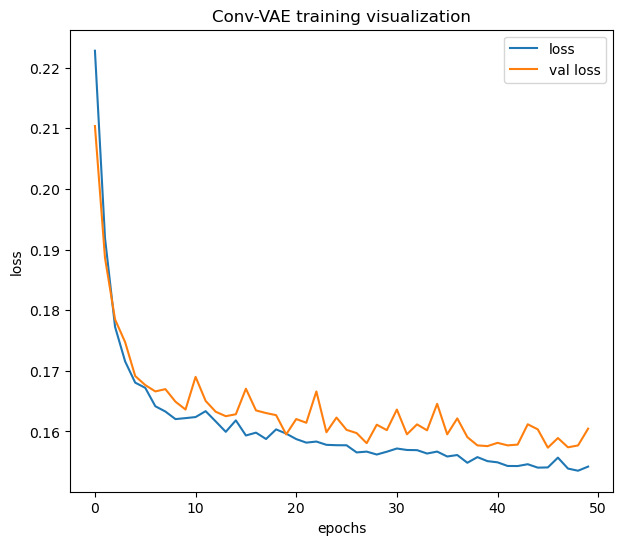

In [58]:
plt.figure(figsize = (7, 6))
plt.plot([train_history[e]['train_loss'] for e in train_history.keys()], label = 'loss')
plt.plot([train_history[e]['val_loss'] for e in train_history.keys()], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Conv-VAE training visualization")
plt.legend(loc = 'best')
plt.show()

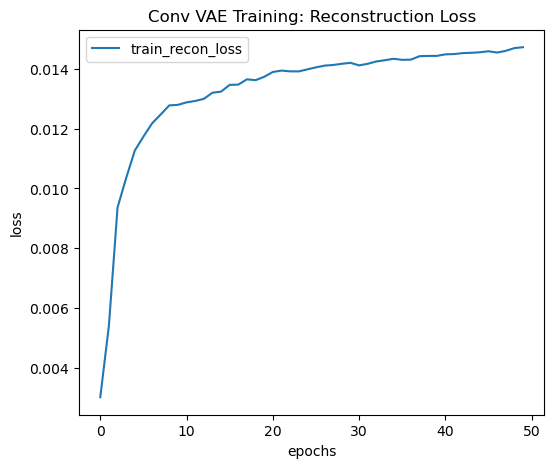

In [73]:
plt.figure(figsize = (6, 5))
plt.plot([train_history[e]['train_recon_loss'] for e in train_history.keys()], label = 'train_recon_loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("Conv VAE Training: Reconstruction Loss")
plt.show()

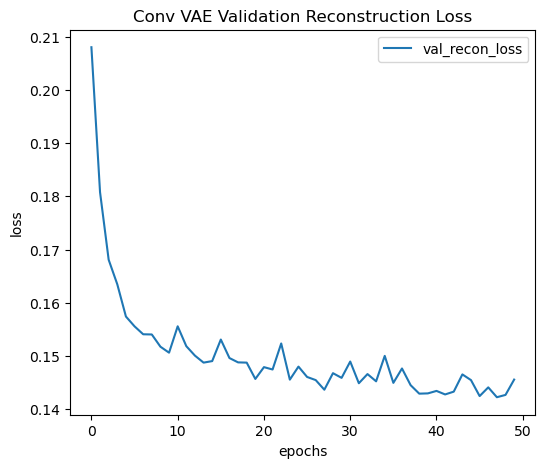

In [74]:
plt.figure(figsize = (6, 5))
plt.plot([train_history[e]['val_recon_loss'] for e in train_history.keys()], label = 'val_recon_loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("Conv VAE Validation Reconstruction Loss")
plt.show()

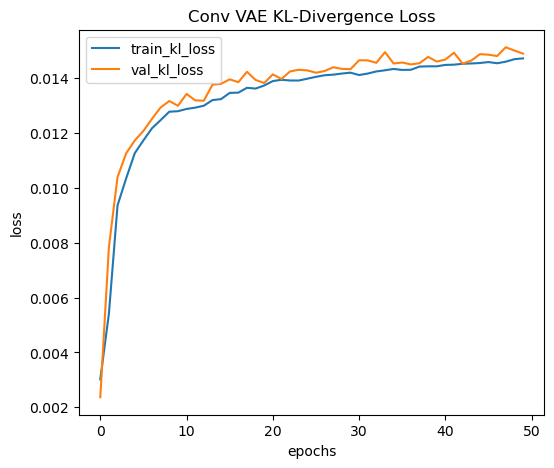

In [75]:
plt.figure(figsize = (6, 5))
plt.plot([train_history[e]['train_kl_loss'] for e in train_history.keys()], label = 'train_kl_loss')
plt.plot([train_history[e]['val_kl_loss'] for e in train_history.keys()], label = 'val_kl_loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("Conv VAE KL-Divergence Loss")
plt.show()

In [72]:
del model

In [62]:
# Load 'best' trained weights from before-
trained_model = Conv_VAE(latent_space = 3).to(device)
trained_model.load_state_dict(torch.load('ConvVAE_MNIST_best_model.pth'))

<All keys matched successfully>

In [68]:
def synthesize_images(model, num_samples = 32):
    # Synthesize new images using trained 'model'.
    z = torch.randn((num_samples, 3)).to(device)
    z = torch.reshape(z, (-1, 3, 1, 1))
    return model.decoder(z).permute((0, 2, 3, 1)).cpu().detach().numpy()


In [69]:
new_images = synthesize_images(model = trained_model, num_samples = 32)

In [70]:
new_images.shape

(32, 28, 28, 1)

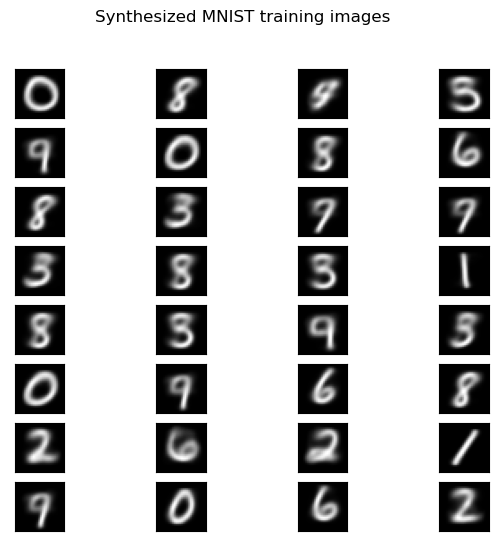

In [71]:
# Visualize images from training set-
plt.figure(figsize = (7, 6))
for i in range(32):
    # 8 rows & 4 columns-
    plt.subplot(8, 4, i + 1)
    # 0 to access first channel-
    plt.imshow(new_images[i], cmap = 'gray')
    
    # get current axes-
    ax = plt.gca()
    
    # hide x-axis-
    ax.get_xaxis().set_visible(False)
    
    # hide y-axis-
    ax.get_yaxis().set_visible(False)
    
plt.suptitle("Synthesized MNIST training images")
plt.show()